<h1><center>Projet ACV</center></h1>

# Imports

In [1]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

import numpy as np
import cv2 # librairie OpenCV

# Filtres statiques

In [11]:
# Conversion de l'image de BGR en RGB

def to_RGB(image):
    """convertit l'image de BGR en RGB"""
    img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return img

In [12]:
# Conversion en HSV

def to_HSV(image):
    """convertit l'image de BGR en HSV"""
    img = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    return img

In [13]:
def filtre_miroir_vertic(image):
    '''Applique un filtre miroir à la verticale de l'image entrée en input'''
    
    height, width = image.shape[:2]
    image_miroir = np.zeros((height, width, 3), 'uint8')
    if width %2 != 0:
        demi_image = image[:,:(width//2)+1]
        demi_image_miroir = np.flip(image[:,:(width//2)], axis = 1)
        image_miroir[:,:(width//2)+1] = demi_image
        image_miroir[:,(width//2)+1:] = demi_image_miroir
    else:
        demi_image = image[:,:(width//2)]
        demi_image_miroir = np.flip(demi_image, axis = 1)
        image_miroir[:,:(width//2)] = demi_image
        image_miroir[:,(width//2):] = demi_image_miroir

    return image_miroir

In [14]:
def filtre_miroir_horiz(image):
    '''Applique un filtre miroir à l'horizontale de l'image entrée en input'''
    height, width = image.shape[:2]
    image_miroir = np.zeros((height, width, 3), 'uint8')

    if height %2 != 0:
        demi_image = image[0:(height//2)+1,:]
        demi_image_miroir = np.flip(image[:height//2,:], axis = 0)
        image_miroir[:(height//2)+1,:] = demi_image
        image_miroir[(height//2)+1:,:] = demi_image_miroir        
    else:
        demi_image = image[0:height//2,:]
        demi_image_miroir = np.flip(demi_image, axis = 0)
        image_miroir[0:height//2,:] = demi_image
        image_miroir[height//2:,:] = demi_image_miroir

    return image_miroir

In [4]:
def filtre_flou(image):
    '''Applique un filtre flou à l'image entrée en input par flou gaussien'''
    blurred = cv2.GaussianBlur(image,(19,19),0)
    return blurred

In [5]:
def filtre_gray(image):
    '''Transforme l'image entrée en input en échelle de gris'''
    grayscale = np.zeros((image.shape[0], image.shape[1], 3), 'uint8') #création d'une image en 3D vide
    grayscale[:,:,0] = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    grayscale[:,:,1] = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    grayscale[:,:,2] = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return grayscale 

In [6]:
def filtre_sepia(image):
    '''Applique un filtre sepia à l'image entrée en input'''
    img_sepia = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    for pixel in img_sepia[:,:,0]:
        pixel[0]=31
    return img_sepia
# NE MARCHE PAS

In [7]:
def filtre_pixel(image):
    """Pixelise l'image"""
    height,width = image.shape[:2]
    img = image[0:height:5, 0:width:5] # le 5 correspond au pas (nb de pixels à sauter)
    img = cv2.resize(img, dsize=(width, height))
    return img

In [8]:
def filtre_cartoon(image):
    """Renvoie l'image avec un effet cartoon"""
    height,width = image.shape[:2]
    tublur = cv2.medianBlur(image, 29)

    edge = cv2.Canny(tublur, 10, 300)
    kernel = np.ones((2,2), np.uint8)
    edge = cv2.dilate(edge, kernel, iterations = 1)
    tublur[edge==255] = 0
    return tublur

# Quadrillage

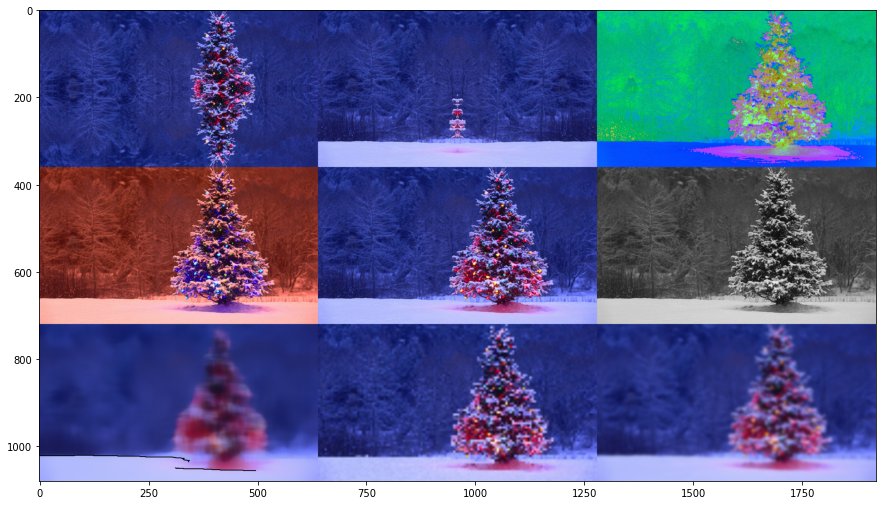

In [15]:
def quadrillage_filtre(image):
    '''Pour l'image donnée en entrée, la fonction affiche un quadrillage en 3 par 3 de l'image transformée par les filtres.
    Les filtres sont fournis en tant que liste de variables.'''
    
    list_filtres = [filtre_miroir_horiz,filtre_miroir_vertic,to_HSV,to_RGB,filtre_gray,filtre_cartoon,filtre_pixel,filtre_flou]

    newheight = image.shape[0]//3
    newwidth = image.shape[1]//3
    img_resized = cv2.resize(image, dsize=(newwidth,newheight)) # on resize l'image de départ en la divisant par 3. attention : width avant height
    quadrillage = np.zeros((img_resized.shape[0]*3, img_resized.shape[1]*3, 3), 'uint8') #création d'un quadrillage vide


    def no_filter(image): # on crée un filtre pour afficher l'image originale
        return image  

    filtres = list_filtres[:4] + [no_filter] + list_filtres[4:] # on veut que l'image originale soit au milieu du quadrillage

    filter_names = ['Miroir horizontal', 'Miroir vertical', 'HSV', 'RGB', 'Original', 'Nuances de gris', 'Cartoon', 'Pixelisé', 'Flou']

    for y in range(3): # pour chaque colonne
        for x in range(3): # pour chaque ligne
            filtre = filtres[3*y+x] # sélection du filtre à appliquer parmi la liste
            img_filtree = filtre(img_resized)
            quadrillage[y*newheight:(y+1)*newheight,x*newwidth:(x+1)*newwidth] = img_filtree
            # cv2.putText(quadrillage[y*newheight:(y+1)*newheight,x*newwidth:(x+1)*newwidth],
            #             filter_names[3*y+x],
            #             (y*newheight, x*newwidth),
            #             cv2.FONT_HERSHEY_SIMPLEX,
            #             1,
            #             (255, 0, 0),
            #             2,
            #             cv2.LINE_AA)

    return quadrillage

# TEST FONCTION
tree = plt.imread('xmas_tree.jpg')
quadrillage = quadrillage_filtre(tree)

plt.figure()
plt.imshow(quadrillage)

# Caméra

## Fonctions de base

In [16]:
def run_filter_on_camera(image_filter):
    cap = cv2.VideoCapture(-1)

    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()
        
        # Our operations on the frame come here
        result_image = image_filter(frame)

        # Display the resulting frame
        cv2.imshow('frame', result_image)

        # We break out of the loop if the 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

## Filtres dynamiques

In [17]:
def black_and_white(image):
    return_image = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return_image[:, :, 0] = gray
    return_image[:, :, 1] = gray
    return_image[:, :, 2] = gray
    
    return return_image

In [18]:
run_filter_on_camera(black_and_white)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to target thread (0x55617d423020)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to target thread (0x55617d423020)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to target thread (0x55617d423020)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to target thread (0x55617d423020)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to target thread (0x55617d423020)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to target thread (0x55617d423020)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to tar

In [26]:
run_filter_on_camera(filtre_cartoon)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to target thread (0x5599b03adc90)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to target thread (0x5599b03adc90)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to target thread (0x5599b03adc90)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to target thread (0x5599b03adc90)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to target thread (0x5599b03adc90)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to target thread (0x5599b03adc90)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to tar

In [19]:
run_filter_on_camera(quadrillage_filtre)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to target thread (0x55617d423020)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to target thread (0x55617d423020)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to target thread (0x55617d423020)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to target thread (0x55617d423020)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to target thread (0x55617d423020)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to target thread (0x55617d423020)

QObject::moveToThread: Current thread (0x55617d423020) is not the object's thread (0x55617eb687e0).
Cannot move to tar

## Holistic

In [20]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

import numpy as np
import cv2 # librairie OpenCV
import mediapipe as mp

drawing_utils = mp.solutions.drawing_utils
drawing_styles = mp.solutions.drawing_styles

In [21]:
def run_filter_with_mediapipe_model(mediapipe_model, mediapipe_based_filter):
    cap = cv2.VideoCapture(-1)
    
    with mediapipe_model as model:
        while cap.isOpened():
            success, image = cap.read()

            if not success:
                print("Ignoring empty camera frame.")
                continue     # If loading a video, use 'break' instead of 'continue'.

            # Flip the image horizontally for a later selfie-view display, and convert
            # the BGR image to RGB.
            image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

            results = model.process(image)

            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            result_image = mediapipe_based_filter(image, results)
            
            cv2.imshow('MediaPipe', result_image)

            if cv2.waitKey(5) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

### Filtre holistic de base

In [34]:
def draw_holistic_results(image, results, show_hands=True, show_face=True, show_pose=False):
    if show_hands:
        drawing_utils.draw_landmarks(
            image,
            results.left_hand_landmarks,
            mp.solutions.holistic.HAND_CONNECTIONS,
            connection_drawing_spec=drawing_styles.get_default_hand_connections_style()
        )

        drawing_utils.draw_landmarks(
            image,
            results.right_hand_landmarks,
            mp.solutions.holistic.HAND_CONNECTIONS,
            connection_drawing_spec=drawing_styles.get_default_hand_connections_style()
        )

    if show_face:
        drawing_utils.draw_landmarks(
            image,
            results.face_landmarks,
            mp.solutions.holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=drawing_utils.DrawingSpec(thickness=0, circle_radius=0, color=(255, 255, 255)),
            connection_drawing_spec=drawing_styles.get_default_face_mesh_contours_style()
        )

    if show_pose:
        drawing_utils.draw_landmarks(
            image,
            results.pose_landmarks,
            mp.solutions.holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=drawing_styles.get_default_pose_landmarks_style()
        )
    
    return image

### Filtre ronds mains

In [35]:
def draw_blob_hand(image, results):
    if (results.right_hand_landmarks != None):
        cv2.circle(image,
            (int(results.right_hand_landmarks.landmark[4].x*image.shape[1]), int(results.right_hand_landmarks.landmark[4].y*image.shape[0])),
            20,
            (255, 0, 0),
            2)
        
    if (results.left_hand_landmarks != None):    
        cv2.circle(image,
            (int(results.left_hand_landmarks.landmark[4].x*image.shape[1]), int(results.left_hand_landmarks.landmark[4].y*image.shape[0])),
            20,
            (50, 168, 82),
            2)
    
    return image

### Filtre OK

In [40]:
def draw_Ok_hand(image, results):
    if (results.right_hand_landmarks != None):
        x4 = int(results.right_hand_landmarks.landmark[4].x*image.shape[1])
        y4 = int(results.right_hand_landmarks.landmark[4].y*image.shape[0])
        x8 = int(results.right_hand_landmarks.landmark[8].x*image.shape[1])
        y8 = int(results.right_hand_landmarks.landmark[8].y*image.shape[0])
        
        if (abs(x8-x4) + abs(y8-y4)) < 20:
            cv2.circle(image,
                (x4, y4),
                20,
                (255, 0, 0),
                2)
    
    return image

### Filtre changement de filtre

In [41]:
def draw_different_filters(image, results):
#     list_filtres = [filtre_miroir_horiz,filtre_miroir_vertic,to_HSV,to_RGB,filtre_gray,filtre_cartoon,filtre_pixel,filtre_flou]

    if (results.right_hand_landmarks != None):
        x4 = int(results.right_hand_landmarks.landmark[4].x*image.shape[1])
        y4 = int(results.right_hand_landmarks.landmark[4].y*image.shape[0])
        x8 = int(results.right_hand_landmarks.landmark[8].x*image.shape[1])
        y8 = int(results.right_hand_landmarks.landmark[8].y*image.shape[0])
        
        if (abs(x8-x4) + abs(y8-y4)) < 30:
            image = black_and_white(image)
    
    return image

## TEST

In [46]:
Holistic = mp.solutions.holistic.Holistic

In [43]:
run_filter_with_mediapipe_model(
    mediapipe_model=Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5),
    mediapipe_based_filter=draw_different_filters
)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to target thread (0x5599b03adc90)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to target thread (0x5599b03adc90)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to target thread (0x5599b03adc90)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to target thread (0x5599b03adc90)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to target thread (0x5599b03adc90)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to target thread (0x5599b03adc90)

QObject::moveToThread: Current thread (0x5599b03adc90) is not the object's thread (0x5599b159c4b0).
Cannot move to tar